This notebook is for preparation data before an analysis

In [16]:
import numpy as np
import pandas as pd
import cooler
from cooltools.api.sample import sample
from cooltools.api.insulation import calculate_insulation_score
from cooltools.api.eigdecomp import eigs_cis
import bioframe

from matplotlib import pyplot as plt
import seaborn as sns

from glob import glob
from tqdm.notebook import tqdm
from natsort import natsorted
from os.path import basename, splitext
import os

# Hi-C

In [2]:
# #paths
# COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
# DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
# INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
# COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
# GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'

# RESOLUTION = 50000
# #FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
# #FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
# FILES = natsorted(glob('%s/nodiags/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
# #FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))

# #CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
# CLRS = [cooler.Cooler(p) for p in FILES]
# LBLS = [os.path.basename(p).split('.')[0] for p in FILES]

# print(LBLS, '\n', [round(c.info['sum']/10**6, 2) for c in CLRS], 'M')

['KO', 'adl', 'old', 'yng']


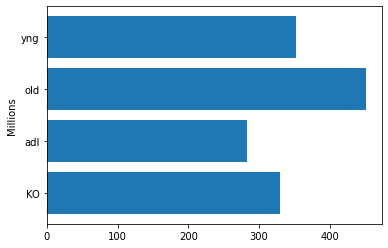

In [17]:
#paths
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
MERGED_COOLER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_coolers'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
MERGED_DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
TMP_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/tmp'

RESOLUTION = 2000
FILES = natsorted(glob('%s/*2000.mcool' % MERGED_COOLER_PATH))
CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
LBLS = [os.path.basename(p).split('.')[0] for p in FILES]
GROUPS = ['adl', 'KO', 'old', 'yng']

print(LBLS)
plt.figure(figsize=(6,4))
plt.barh(LBLS, [round(c.info['sum']/10**6, 2) for c in CLRS])
plt.ylabel('Millions');


In [162]:
for c in CLRS:
    pix = c.pixels()[:]
    k = pix[(pix['bin1_id'] == pix['bin2_id']) | 
        ((pix['bin1_id']+1) == pix['bin2_id']) ]['count'].sum() / pix['count'].sum()
    print(k)

0.11669494673182117
0.11694423755017865
0.13905662269494937
0.1219983377667271


## coolers

In [10]:
#merge coolers using RESOLUTION as base resolution
resolutions = [2000, 4000, 10_000, 20_000, 50_000, 100_000, 200_000, 1_000_000]
remove_tmp = True
#extract coolers from initial .mcools
for c, l in zip(CLRS, LBLS):
    cooler.create_cooler('%s/%s_%d.cool' % (TMP_FOLDER_PATH, l, RESOLUTION),
                             bins=c.bins()[:],
                             pixels=c.pixels()[:],
                            )    
#merge coolers by groups
tmpFILES = natsorted(glob(TMP_FOLDER_PATH + '/*'))
for g in GROUPS:
    group = [f for f in tmpFILES if g in f]
    cooler.merge_coolers(MERGED_COOLER_PATH + '/%s_%d.cool' % (g, RESOLUTION), 
                         group, 
                         mergebuf=200_000_000)
#zoomify based on base RESOLUTION making .mcool files
tmpFILES = natsorted(glob(MERGED_COOLER_PATH + '/*.cool'))
for g in GROUPS:
    cooler.zoomify_cooler([f for f in tmpFILES if g in f], 
                          MERGED_COOLER_PATH + '/%s.%d.mcool' % (g, RESOLUTION), 
                          resolutions,
                          chunksize=100_000_000, nproc=20)
#erase tmp base files    
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)

#erase tmp folder   
for f in glob(TMP_FOLDER_PATH + '/*'):
    os.remove(f)

In [27]:
#os.system(f'cooler ls {mcool file} | xargs -n1 cooler balance {balance args}') # for dry run

# balancing
forbalancing = glob(MERGED_COOLER_PATH + '/*2000.mcool')
for mcool in forbalancing:
    os.system(f"cooler ls {mcool} | xargs -n1 cooler balance")

INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/KO.2000.mcool::/resolutions/2000"
INFO:cooler.balance:variance is 34491.17543182411
INFO:cooler.balance:variance is 15525.983015318603
INFO:cooler.balance:variance is 2730.2853032448484
INFO:cooler.balance:variance is 3422.027025980827
INFO:cooler.balance:variance is 1060.575766527889
INFO:cooler.balance:variance is 1129.697432519351
INFO:cooler.balance:variance is 465.39124089789857
INFO:cooler.balance:variance is 445.74154113590544
INFO:cooler.balance:variance is 218.79731434485998
INFO:cooler.balance:variance is 193.19674575336467
INFO:cooler.balance:variance is 106.65476054493874
INFO:cooler.balance:variance is 88.48896388885905
INFO:cooler.balance:variance is 52.93529084856304
INFO:cooler.balance:variance is 41.95173935445523
INFO:cooler.balance:variance is 26.51312889605005
INFO:cooler.balance:variance is 20.338340326420933
INFO:cooler.balance:variance is 13.345503110715294
INFO:cooler.balance:

INFO:cooler.balance:variance is 1.866455731649358
INFO:cooler.balance:variance is 1.283864513174043
INFO:cooler.balance:variance is 0.9028282832934748
INFO:cooler.balance:variance is 0.6234773864020695
INFO:cooler.balance:variance is 0.4371341674119478
INFO:cooler.balance:variance is 0.3027021789436024
INFO:cooler.balance:variance is 0.2118041129305766
INFO:cooler.balance:variance is 0.1469459149711528
INFO:cooler.balance:variance is 0.10267999312559203
INFO:cooler.balance:variance is 0.07133160410192527
INFO:cooler.balance:variance is 0.04979825584792111
INFO:cooler.balance:variance is 0.03462676054734425
INFO:cooler.balance:variance is 0.024159081954903093
INFO:cooler.balance:variance is 0.01680976511360497
INFO:cooler.balance:variance is 0.011723492201781746
INFO:cooler.balance:variance is 0.008160941049325326
INFO:cooler.balance:variance is 0.0056901523174333205
INFO:cooler.balance:variance is 0.003962350095219297
INFO:cooler.balance:variance is 0.002762272862570136
INFO:cooler.bal

INFO:cooler.balance:variance is 0.04330005384257957
INFO:cooler.balance:variance is 0.029996822884393527
INFO:cooler.balance:variance is 0.020809441188914157
INFO:cooler.balance:variance is 0.014420416503598097
INFO:cooler.balance:variance is 0.010002734335586582
INFO:cooler.balance:variance is 0.006933229225783536
INFO:cooler.balance:variance is 0.004808979648202684
INFO:cooler.balance:variance is 0.0033338548895332537
INFO:cooler.balance:variance is 0.0023123545305202362
INFO:cooler.balance:variance is 0.0016032775186916137
INFO:cooler.balance:variance is 0.0011120286167843362
INFO:cooler.balance:variance is 0.0007711142242992738
INFO:cooler.balance:variance is 0.0005348492932548062
INFO:cooler.balance:variance is 0.00037091438864165653
INFO:cooler.balance:variance is 0.0002572737716649409
INFO:cooler.balance:variance is 0.00017843108685776038
INFO:cooler.balance:variance is 0.00012376664066076788
INFO:cooler.balance:variance is 8.584326057597802e-05
INFO:cooler.balance:variance is 5

INFO:cooler.balance:variance is 4645.725758544547
INFO:cooler.balance:variance is 3063.92382834041
INFO:cooler.balance:variance is 2797.224399646828
INFO:cooler.balance:variance is 1913.666309220521
INFO:cooler.balance:variance is 1697.7113715050916
INFO:cooler.balance:variance is 1196.21525213393
INFO:cooler.balance:variance is 1036.5412111785647
INFO:cooler.balance:variance is 747.7567500256049
INFO:cooler.balance:variance is 635.6790041812216
INFO:cooler.balance:variance is 467.2396326076656
INFO:cooler.balance:variance is 391.1365812730908
INFO:cooler.balance:variance is 291.7883402820487
INFO:cooler.balance:variance is 241.26571384576846
INFO:cooler.balance:variance is 182.10551427814642
INFO:cooler.balance:variance is 149.09765045832685
INFO:cooler.balance:variance is 113.58320608057291
INFO:cooler.balance:variance is 92.26878917392067
INFO:cooler.balance:variance is 70.80519627090246
INFO:cooler.balance:variance is 57.16096213537182
INFO:cooler.balance:variance is 44.11702198180

INFO:cooler.balance:variance is 3.363699905455573e-05
INFO:cooler.balance:variance is 2.0829510638424892e-05
INFO:cooler.balance:variance is 1.289854479845231e-05
INFO:cooler.balance:variance is 7.987349877212065e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/adl.2000.mcool::/resolutions/2000"
INFO:cooler.balance:variance is 24809.658455253597
INFO:cooler.balance:variance is 10779.54469810041
INFO:cooler.balance:variance is 2514.5796027545125
INFO:cooler.balance:variance is 2715.130071868104
INFO:cooler.balance:variance is 974.2809080843452
INFO:cooler.balance:variance is 930.1943661975478
INFO:cooler.balance:variance is 411.00519787694344
INFO:cooler.balance:variance is 361.7079998796719
INFO:cooler.balance:variance is 183.1095947947467
INFO:cooler.balance:variance is 151.1738583294069
INFO:cooler.balance:variance is 84.26105209395337
INFO:cooler.balance:variance is 66.20887831841134
INFO:cooler.balance:variance is 39.50072989549223
INFO:coo

INFO:cooler.balance:variance is 0.07329928968680476
INFO:cooler.balance:variance is 0.04947887066694188
INFO:cooler.balance:variance is 0.03332959593759278
INFO:cooler.balance:variance is 0.022497400924123664
INFO:cooler.balance:variance is 0.015165682930064303
INFO:cooler.balance:variance is 0.010237612884544917
INFO:cooler.balance:variance is 0.006905274842327731
INFO:cooler.balance:variance is 0.004662112583009153
INFO:cooler.balance:variance is 0.0031460906383082325
INFO:cooler.balance:variance is 0.0021244917514596793
INFO:cooler.balance:variance is 0.001434222939789608
INFO:cooler.balance:variance is 0.000968703515922539
INFO:cooler.balance:variance is 0.0006541863088485989
INFO:cooler.balance:variance is 0.00044194581600002315
INFO:cooler.balance:variance is 0.0002985453723252661
INFO:cooler.balance:variance is 0.00020173020445964258
INFO:cooler.balance:variance is 0.00013631034840812082
INFO:cooler.balance:variance is 9.212554243677599e-05
INFO:cooler.balance:variance is 6.2264

INFO:cooler.balance:variance is 3489.474404966785
INFO:cooler.balance:variance is 3449.362905677872
INFO:cooler.balance:variance is 1952.5542966474068
INFO:cooler.balance:variance is 1814.7652282976135
INFO:cooler.balance:variance is 1094.6772194589555
INFO:cooler.balance:variance is 968.8689477120564
INFO:cooler.balance:variance is 614.3178756680309
INFO:cooler.balance:variance is 523.3051401410399
INFO:cooler.balance:variance is 344.9551654738305
INFO:cooler.balance:variance is 285.27807405469304
INFO:cooler.balance:variance is 193.8080789838175
INFO:cooler.balance:variance is 156.68236285917584
INFO:cooler.balance:variance is 108.95936643505222
INFO:cooler.balance:variance is 86.57865280065302
INFO:cooler.balance:variance is 61.30687313019924
INFO:cooler.balance:variance is 48.082201877901895
INFO:cooler.balance:variance is 34.528414703015756
INFO:cooler.balance:variance is 26.815954964080547
INFO:cooler.balance:variance is 19.46838355204911
INFO:cooler.balance:variance is 15.009696

INFO:cooler.balance:variance is 7.608244159014447e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/adl.2000.mcool::/resolutions/1000000"
INFO:cooler.balance:variance is 563096928.0437493
INFO:cooler.balance:variance is 67721223699.1202
INFO:cooler.balance:variance is 304568287.5257012
INFO:cooler.balance:variance is 6518125446.239255
INFO:cooler.balance:variance is 169135748.98724523
INFO:cooler.balance:variance is 892616253.1896101
INFO:cooler.balance:variance is 77000125.16290666
INFO:cooler.balance:variance is 173775830.8758723
INFO:cooler.balance:variance is 31124861.56970736
INFO:cooler.balance:variance is 41818624.32661914
INFO:cooler.balance:variance is 11774670.54864563
INFO:cooler.balance:variance is 11385026.514281806
INFO:cooler.balance:variance is 4246060.73901735
INFO:cooler.balance:variance is 3331561.708144728
INFO:cooler.balance:variance is 1475884.4692320717
INFO:cooler.balance:variance is 1017219.3770652077
INFO:cooler.balance

INFO:cooler.balance:variance is 0.9941847755327272
INFO:cooler.balance:variance is 0.6989116481004426
INFO:cooler.balance:variance is 0.4976410721070301
INFO:cooler.balance:variance is 0.35081454110754234
INFO:cooler.balance:variance is 0.2495324690261781
INFO:cooler.balance:variance is 0.17626364618788268
INFO:cooler.balance:variance is 0.12529654349238337
INFO:cooler.balance:variance is 0.08863699673147142
INFO:cooler.balance:variance is 0.06298396528391928
INFO:cooler.balance:variance is 0.044604576081719076
INFO:cooler.balance:variance is 0.03168876863345745
INFO:cooler.balance:variance is 0.02245992161350609
INFO:cooler.balance:variance is 0.015954801996062157
INFO:cooler.balance:variance is 0.011315156329378809
INFO:cooler.balance:variance is 0.008037666035695473
INFO:cooler.balance:variance is 0.005702974762348995
INFO:cooler.balance:variance is 0.004051115751902395
INFO:cooler.balance:variance is 0.0028754196248783124
INFO:cooler.balance:variance is 0.002042623675193817
INFO:co

INFO:cooler.balance:variance is 0.0044755537190459965
INFO:cooler.balance:variance is 0.003084429084053769
INFO:cooler.balance:variance is 0.0021246987029733422
INFO:cooler.balance:variance is 0.0014641856851955934
INFO:cooler.balance:variance is 0.0010086835970639114
INFO:cooler.balance:variance is 0.000695080894569855
INFO:cooler.balance:variance is 0.00047887322697425893
INFO:cooler.balance:variance is 0.00032998171027315157
INFO:cooler.balance:variance is 0.00022734985171508706
INFO:cooler.balance:variance is 0.00015665990845962512
INFO:cooler.balance:variance is 0.00010793879279572644
INFO:cooler.balance:variance is 7.437688358160333e-05
INFO:cooler.balance:variance is 5.12470963533117e-05
INFO:cooler.balance:variance is 3.531255630240279e-05
INFO:cooler.balance:variance is 2.433154833159123e-05
INFO:cooler.balance:variance is 1.676604432811287e-05
INFO:cooler.balance:variance is 1.1552577394033178e-05
INFO:cooler.balance:variance is 7.960524943120668e-06
INFO:cooler.cli.balance:B

INFO:cooler.balance:variance is 1.1703421585499367
INFO:cooler.balance:variance is 0.9221367263652736
INFO:cooler.balance:variance is 0.7344375704903683
INFO:cooler.balance:variance is 0.5795181405001804
INFO:cooler.balance:variance is 0.46125472384206473
INFO:cooler.balance:variance is 0.3643989573375639
INFO:cooler.balance:variance is 0.2898942359896988
INFO:cooler.balance:variance is 0.22925262050327838
INFO:cooler.balance:variance is 0.1823158218799799
INFO:cooler.balance:variance is 0.1443004753961881
INFO:cooler.balance:variance is 0.11472865067969056
INFO:cooler.balance:variance is 0.09087136918016879
INFO:cooler.balance:variance is 0.07223734101491122
INFO:cooler.balance:variance is 0.05725088480774771
INFO:cooler.balance:variance is 0.04550676001672285
INFO:cooler.balance:variance is 0.03608473186382845
INFO:cooler.balance:variance is 0.028681264971378354
INFO:cooler.balance:variance is 0.02275315312551852
INFO:cooler.balance:variance is 0.018084831918621636
INFO:cooler.balanc

INFO:cooler.balance:variance is 35.617998345812154
INFO:cooler.balance:variance is 31.945459316261342
INFO:cooler.balance:variance is 27.97484823487155
INFO:cooler.balance:variance is 25.05517157015772
INFO:cooler.balance:variance is 21.970012225656948
INFO:cooler.balance:variance is 19.652578242084463
INFO:cooler.balance:variance is 17.252865584049296
INFO:cooler.balance:variance is 15.416000342561777
INFO:cooler.balance:variance is 13.547655746950928
INFO:cooler.balance:variance is 12.093457285016052
INFO:cooler.balance:variance is 10.63756497207865
INFO:cooler.balance:variance is 9.487521695498732
INFO:cooler.balance:variance is 8.35214996146813
INFO:cooler.balance:variance is 7.443478506671175
INFO:cooler.balance:variance is 6.557447621074799
INFO:cooler.balance:variance is 5.840063376949538
INFO:cooler.balance:variance is 5.148184309153269
INFO:cooler.balance:variance is 4.582215764011797
INFO:cooler.balance:variance is 4.041643662799729
INFO:cooler.balance:variance is 3.595406456

INFO:cooler.balance:variance is 63.87817709081736
INFO:cooler.balance:variance is 43.94833087259782
INFO:cooler.balance:variance is 30.21598956591369
INFO:cooler.balance:variance is 20.78669464643298
INFO:cooler.balance:variance is 14.293241624849275
INFO:cooler.balance:variance is 9.8322272216712
INFO:cooler.balance:variance is 6.761347778895554
INFO:cooler.balance:variance is 4.650893092826794
INFO:cooler.balance:variance is 3.1984782067351967
INFO:cooler.balance:variance is 2.200060864231624
INFO:cooler.balance:variance is 1.5130737004905206
INFO:cooler.balance:variance is 1.0407437980175842
INFO:cooler.balance:variance is 0.7157846794288374
INFO:cooler.balance:variance is 0.49233580133785826
INFO:cooler.balance:variance is 0.33861758545565446
INFO:cooler.balance:variance is 0.23290867488501799
INFO:cooler.balance:variance is 0.1601919489028449
INFO:cooler.balance:variance is 0.11018315427302379
INFO:cooler.balance:variance is 0.07578361255388974
INFO:cooler.balance:variance is 0.05

INFO:cooler.balance:variance is 0.236240722213475
INFO:cooler.balance:variance is 0.17484205973980202
INFO:cooler.balance:variance is 0.12886220489359201
INFO:cooler.balance:variance is 0.09535478431824462
INFO:cooler.balance:variance is 0.07034703957188426
INFO:cooler.balance:variance is 0.05205173507266004
INFO:cooler.balance:variance is 0.03843016923247196
INFO:cooler.balance:variance is 0.02843572868127404
INFO:cooler.balance:variance is 0.021007126951391043
INFO:cooler.balance:variance is 0.015544627269450871
INFO:cooler.balance:variance is 0.011489341733606849
INFO:cooler.balance:variance is 0.008502400501307978
INFO:cooler.balance:variance is 0.006286777603661849
INFO:cooler.balance:variance is 0.0046527872449920165
INFO:cooler.balance:variance is 0.0034414346193541957
INFO:cooler.balance:variance is 0.0025472157425152206
INFO:cooler.balance:variance is 0.0018845458052498046
INFO:cooler.balance:variance is 0.001394999804248744
INFO:cooler.balance:variance is 0.001032309139687378

INFO:cooler.balance:variance is 0.9429876642015238
INFO:cooler.balance:variance is 0.670775236009813
INFO:cooler.balance:variance is 0.4760059919323885
INFO:cooler.balance:variance is 0.3385994557468923
INFO:cooler.balance:variance is 0.24047600945188127
INFO:cooler.balance:variance is 0.17107909856791698
INFO:cooler.balance:variance is 0.1215823948290431
INFO:cooler.balance:variance is 0.08651225921667427
INFO:cooler.balance:variance is 0.06151692667207094
INFO:cooler.balance:variance is 0.043782601279786726
INFO:cooler.balance:variance is 0.03114787487864324
INFO:cooler.balance:variance is 0.022174067011732863
INFO:cooler.balance:variance is 0.01578181110394727
INFO:cooler.balance:variance is 0.011237982751693394
INFO:cooler.balance:variance is 0.008001379610589747
INFO:cooler.balance:variance is 0.005699174553878636
INFO:cooler.balance:variance is 0.004059176187534471
INFO:cooler.balance:variance is 0.0028920058745490486
INFO:cooler.balance:variance is 0.0020604486537315232
INFO:coo

INFO:cooler.balance:variance is 1.0468382851350537e-05
INFO:cooler.balance:variance is 8.624262516314568e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/old.2000.mcool::/resolutions/100000"
INFO:cooler.balance:variance is 35755040.949466944
INFO:cooler.balance:variance is 3843712963.597819
INFO:cooler.balance:variance is 17168485.62664494
INFO:cooler.balance:variance is 481171090.4230401
INFO:cooler.balance:variance is 8509190.30435856
INFO:cooler.balance:variance is 92477375.55613425
INFO:cooler.balance:variance is 4406819.932087987
INFO:cooler.balance:variance is 24892214.469882753
INFO:cooler.balance:variance is 2321659.9691278366
INFO:cooler.balance:variance is 8345100.77500016
INFO:cooler.balance:variance is 1218547.2225553927
INFO:cooler.balance:variance is 3238212.588313624
INFO:cooler.balance:variance is 638276.3533400053
INFO:cooler.balance:variance is 1392196.5653940882
INFO:cooler.balance:variance is 337670.8151286996
INFO:cooler.ba

INFO:cooler.balance:variance is 151801.59299766368
INFO:cooler.balance:variance is 69697.6197757515
INFO:cooler.balance:variance is 92930.31481380743
INFO:cooler.balance:variance is 46635.80228385506
INFO:cooler.balance:variance is 58010.70055645302
INFO:cooler.balance:variance is 31452.52167017853
INFO:cooler.balance:variance is 36793.03404831548
INFO:cooler.balance:variance is 21324.63784874111
INFO:cooler.balance:variance is 23640.625420927478
INFO:cooler.balance:variance is 14506.965332099075
INFO:cooler.balance:variance is 15351.615681526588
INFO:cooler.balance:variance is 9889.3801968066
INFO:cooler.balance:variance is 10055.627617985123
INFO:cooler.balance:variance is 6749.526740201591
INFO:cooler.balance:variance is 6633.436697204605
INFO:cooler.balance:variance is 4609.309673130987
INFO:cooler.balance:variance is 4401.325283859127
INFO:cooler.balance:variance is 3148.4399989429057
INFO:cooler.balance:variance is 2934.188231523213
INFO:cooler.balance:variance is 2150.5680425363

INFO:cooler.balance:variance is 320687.1869607166
INFO:cooler.balance:variance is 273738.19732644863
INFO:cooler.balance:variance is 196209.4970962038
INFO:cooler.balance:variance is 164268.9181129146
INFO:cooler.balance:variance is 119920.32004341726
INFO:cooler.balance:variance is 98879.42012044135
INFO:cooler.balance:variance is 73231.4705542544
INFO:cooler.balance:variance is 59663.58400888436
INFO:cooler.balance:variance is 44690.441839255116
INFO:cooler.balance:variance is 36069.95911087539
INFO:cooler.balance:variance is 27258.8372193051
INFO:cooler.balance:variance is 21839.38728453123
INFO:cooler.balance:variance is 16619.823208812366
INFO:cooler.balance:variance is 13239.011793102696
INFO:cooler.balance:variance is 10130.051163262013
INFO:cooler.balance:variance is 8033.071156229729
INFO:cooler.balance:variance is 6172.968917193926
INFO:cooler.balance:variance is 4877.890386470901
INFO:cooler.balance:variance is 3760.952624824497
INFO:cooler.balance:variance is 2963.728485782

In [10]:
#pure downsampling procedure
# if not os.path.exists(DOWNSAMPLED_FOLDER_PATH):
#     os.makedirs(DOWNSAMPLED_FOLDER_PATH)

# MIN_SUM = min([c.info['sum'] for c in CLRS])
# print('Minimal count sum:', MIN_SUM)
# for l, c in zip(LBLS, CLRS):
#     sample(c, '%s/%s_down_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, RESOLUTION), 
#                   count=MIN_SUM//1000*1000, 
#                   exact=False,
#                   chunksize=100_000_000)

INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_female_2_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(data):
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_female_3_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_male_1_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:coole

In [115]:
#downsampling procedure with first m diagonals removal
if not os.path.exists(DOWNSAMPLED_FOLDER_PATH):
    os.makedirs(DOWNSAMPLED_FOLDER_PATH)
m = 2 #number of diags for removing
remove_tmp = True

#erasing m diags
for l, c in zip(LBLS, CLRS):
    pix = c.pixels()[:]
    for k in range(m):
        pix.loc[(pix.bin1_id + k) == (pix.bin2_id), 'count'] = 0
    cooler.create_cooler('%s/%s_no_%d_diags_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION),
                         bins=c.bins()[:],
                         pixels=pix,
                        )
tmpFILES = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*diags_*.cool'))
tmpCLRS = [cooler.Cooler(p) for p in tmpFILES]

MIN_SUM = min([c.info['sum'] for c in tmpCLRS])
print('Minimal count sum:', MIN_SUM)
for l, c in zip(LBLS, tmpCLRS):
    sample(c, '%s/%s_down_no_%d_diags_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION), 
                  count=MIN_SUM//1000*1000, 
                  exact=False,
                  chunksize=100_000_000)
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)
        
tmpFILES = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*_down*diags*.cool'))
for f, l in zip(tmpFILES, LBLS):
    cooler.zoomify_cooler([f], 
                      DOWNSAMPLED_FOLDER_PATH + '/%s_down_no_%d_diag_%d.mcool' % (l, m, RESOLUTION), 
                      resolutions,
                      chunksize=100_000_000, nproc=20)
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)

INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_f_2_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(data):
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_f_3_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_m_1_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:

Minimal count sum: 50121444


INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_f_3_down_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_m_1_down_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/adl_f_2_down_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:

In [147]:
#downsampling procedure with first m diagonals removal on merged
if not os.path.exists(MERGED_DOWNSAMPLED_FOLDER_PATH):
    os.makedirs(MERGED_DOWNSAMPLED_FOLDER_PATH)
m = 2 #number of diags for removing
remove_tmp = True

#erasing m diags
for l, c in zip(LBLS, CLRS):
    pix = c.pixels()[:]
    for k in range(m):
        pix.loc[(pix.bin1_id + k) == (pix.bin2_id), 'count'] = 0
    cooler.create_cooler('%s/%s_no_%d_diags_%d.cool' % (MERGED_DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION),
                         bins=c.bins()[:],
                         pixels=pix,
                        )
tmpFILES = natsorted(glob(MERGED_DOWNSAMPLED_FOLDER_PATH + '/*diags_*.cool'))
tmpCLRS = [cooler.Cooler(p) for p in tmpFILES]

MIN_SUM = min([c.info['sum'] for c in tmpCLRS])
print('Minimal count sum:', MIN_SUM)
for l, c in zip(LBLS, tmpCLRS):
    sample(c, '%s/%s_down_no_%d_diags_%d.cool' % (MERGED_DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION), 
                  count=MIN_SUM//1000*1000, 
                  exact=False,
                  chunksize=100_000_000)
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)
        
tmpFILES = natsorted(glob(MERGED_DOWNSAMPLED_FOLDER_PATH + '/*_down*diags*.cool'))
for f, l in zip(tmpFILES, LBLS):
    cooler.zoomify_cooler([f], 
                      MERGED_DOWNSAMPLED_FOLDER_PATH + '/%s_down_no_%d_diag.%d.mcool' % (l, m, RESOLUTION), 
                      resolutions,
                      chunksize=100_000_000, nproc=20)
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)

INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/KO_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/adl_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/old_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/yng_no_2_diags_10000.cool::/"


Minimal count sum: 194380176


INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/adl_down_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/old_down_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/yng_down_no_2_diags_10000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Copying base matrices a

INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:100001304 117161539
INFO:cooler.reduce:0 100001304
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 10000 to 50000.
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bins["chrom"])
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/old_down_no_2_diag.10000.mcool::/resolutions/50000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:100000952 117161539
INFO:cooler.reduce:0 100000952
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 50000 to 100000.
/home/dkriukov/mi

## insulation score

In [12]:
#insulation scores
if not os.path.exists(INSULATION_PATH):
    os.makedirs(INSULATION_PATH)

df = pd.DataFrame()
for l, c in zip(LBLS, CLRS):
    IS = calculate_insulation_score(c, 
                                    window_bp=[RESOLUTION * 10], 
                                    ignore_diags=2, 
                                    append_raw_scores=False)
    df[l] = np.array(IS.filter(regex=("log2*"))).squeeze()


##additional masking around NaN
binstatus = pd.DataFrame({basename(c.filename):c.bins()[:]['weight'] for c in CLRS})

k = 11 #left and right around nan will be nan to avoid `edge effect`
N = df.shape[0]
nanids = binstatus[binstatus.isna().any(1)].index.tolist()
for i in nanids:
    l = i - k if i - k >=0 else 0
    r = i + k if i + k < N else N
    df.iloc[l:r] = np.nan

#postprocessing
IS_info = IS[['chrom', 'start', 'end']].reset_index()
IS_info['index'] = IS_info['index'].apply(str
                                         )
df = df.reset_index()
df['index'] = df['index'].apply(str)
df = df.merge(IS_info, on='index')
df.to_csv('%s/IS_merged_new_%s.csv' % (INSULATION_PATH, RESOLUTION))
#df.to_csv('%s/IS_merged_%s.csv' % (INSULATION_PATH, RESOLUTION))

## Compartments

In [6]:
!ls /tank/projects/kriukov_chromatin/HIC/compartments

combined_KO_down_50000_50000.cis.lam.txt      old_female_3_50000.cis.lam.txt
combined_KO_down_50000_50000.cis.vecs.txt     old_female_3_50000.cis.vecs.txt
combined_old_down_50000_50000.cis.lam.txt     old_male_1_50000.cis.lam.txt
combined_old_down_50000_50000.cis.vecs.txt    old_male_1_50000.cis.vecs.txt
combined_WT_down_50000_50000.cis.lam.txt      WT_female_2_50000.cis.lam.txt
combined_WT_down_50000_50000.cis.vecs.txt     WT_female_2_50000.cis.vecs.txt
combined_young_down_50000_50000.cis.lam.txt   WT_female_3_50000.cis.lam.txt
combined_young_down_50000_50000.cis.vecs.txt  WT_female_3_50000.cis.vecs.txt
KO_female_2_50000.cis.lam.txt		      WT_male_1_50000.cis.lam.txt
KO_female_2_50000.cis.vecs.txt		      WT_male_1_50000.cis.vecs.txt
KO_female_3_50000.cis.lam.txt		      young_female_2_50000.cis.lam.txt
KO_female_3_50000.cis.vecs.txt		      young_female_2_50000.cis.vecs.txt
KO_male_1_50000.cis.lam.txt		      young_female_3_50000.cis.lam.txt
KO_male_1_50000.cis.vecs.txt		      young_fema

In [7]:
# compartments
if not os.path.exists(COMPARTMENTS_PATH):
    os.makedirs(COMPARTMENTS_PATH)

mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)

In [8]:
bins = cooler.binnify(mm10, binsize=RESOLUTION)
fasta_records = bioframe.load_fasta('%s/GCF_000001635.27_GRCm39_genomic.fna' % GENOME_FOLDER_PATH)

###CONVERT REFSEQ to CHROMNAMES
fasta_annot = pd.read_csv('%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH, sep='\t', skiprows=28)
fasta_annot = fasta_annot[fasta_annot['Sequence-Role']=='assembled-molecule']
fasta_keys = fasta_annot[['Assigned-Molecule', 'RefSeq-Accn']].set_index('RefSeq-Accn')
filt_keys = fasta_keys.loc[list(set(list(fasta_records.keys())).intersection(fasta_keys.index))].to_dict()
new_dict = {}
for key, item in fasta_records.items():
    if key in filt_keys['Assigned-Molecule'].keys():
        nk = 'chr' + filt_keys['Assigned-Molecule'][key]
        nk = 'chrM' if nk == 'chrMT' else nk
        new_dict[nk] = item
        
gc = bioframe.frac_gc(bins, new_dict)

#######
bins['GC'] = gc['GC']
bins = bins.drop(bins[bins.chrom=='chrM'].index)

##additional masking around NaN
binstatus = pd.DataFrame({basename(c.filename):c.bins()[:]['weight'] for c in CLRS})
mask_indices = binstatus[binstatus.isna().any(1)].index

In [9]:
lam = {}
eigs = {}

for l,c in zip(LBLS, CLRS):
    lam[l], eigs[l] = eigs_cis(
        c,
        phasing_track=bins,
        n_eigs=8,
        bad_bins=mask_indices,
        ignore_diags=2,
        sort_metric='var_explained')

    # Save text files
    lam[l].to_csv(f'{COMPARTMENTS_PATH}/{l}_{RESOLUTION}.cis.lam.txt', sep='\t')
    eigs[l].to_csv(f'{COMPARTMENTS_PATH}/{l}_{RESOLUTION}.cis.vecs.txt', sep='\t', index=False)

# ATAC-seq

# RNA-seq

* neural stem cells (NSC), 
* astrocyte-restricted precursors (ARP),
* astrocytes (ASC), 
* oligodendrocyte precursor cells (OPC), 
* oligodendrocytes (OLG), 
* lfactory ensheathing glia (OEG), 
* neuronal-restricted precursors (NRP), 
* immature neurons (ImmN), 
* mature neurons (mNEUR),
* neuroendocrine cells (NendC), 
* ependymocytes (EPC), 
* hypendymal cells (HypEPC), 
* tanycytes (TNC), 
* choroid plexus epithelial cells (CPC), 
* endothelial cells (EC), 
* pericytes (PC), 
* vascular smooth muscle cells (VSMC), 
* hemoglobin-expressing vascular cells (Hb-VC), 
* vascular and leptomeningeal cells (VLMC), 
* arachnoid barrier cells (ABC), 
* microglia (MG), 
* monocytes (MNC), 
* macrophages (MAC), 
* dendritic cells (DC) 
* neutrophils (NEUT)

## pseudobulk DE

In [2]:
rna_list = natsorted(glob('/tank/projects/kriukov_chromatin/RNA/GSE129788/*X.txt'))
genes = pd.read_csv(rna_list[0], '\t').index.tolist()
ann = pd.read_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/GSE129788_Supplementary_meta_data_Cell_Types_Etc.txt', sep='\t')
ann = ann.drop(0)
ann['ID'] = ann.NAME.apply(lambda x: x.split('data_')[1])
ann['miceID'] = ann.ID.apply(lambda x: x.split('_')[0])
ann['ageID'] = ann['animal_type'] + '_' +ann['miceID']
ann = ann.set_index('ID')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ann.cell_classes.value_counts()

OLG_Lin       15463
ASC_Lin        7097
NEURON_Lin     5773
IMMUNE_Lin     4448
VASC_Lin       3884
EPC_Lin         404
Name: cell_classes, dtype: int64

In [4]:
ann.head()

,NAME,nGene,nUMI,cluster,animal_type,cell_classes,cell_type_age,miceID,ageID
ID,,,,,,,,,
6_AAACCTGAGGCCCTTG,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,1546,3546,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AAACGGGAGAGACGAA,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,734,1589,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AAAGTAGCAACGATCT,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,456,1129,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AACCGCGCAACAACCT,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,1236,2697,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AACTCCCAGTACGTAA,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,622,1115,MG,young,IMMUNE_Lin,MG_young,6,young_6


In [12]:
print('Cell classes:', ann.cell_classes.unique(), '\n')
print('Cell types:\n', ann.cell_type_age.unique())

Cell classes: ['IMMUNE_Lin' 'OLG_Lin' 'NEURON_Lin' 'VASC_Lin' 'ASC_Lin' 'EPC_Lin'] 

Cell types:
 ['MG_young' 'MG_old' 'NEUT_young' 'NEUT_old' 'DC_old' 'DC_young' 'MAC_old'
 'MAC_young' 'OLG_young' 'OLG_old' 'OPC_young' 'OPC_old' 'OEG_young'
 'OEG_old' 'mNEUR_young' 'mNEUR_old' 'NendC_young' 'NendC_old'
 'ImmN_young' 'ImmN_old' 'ABC_young' 'ABC_old' 'VLMC_young' 'VLMC_old'
 'EC_young' 'EC_old' 'VSMC_young' 'VSMC_old' 'ASC_young' 'ASC_old'
 'NSC_young' 'NSC_old' 'ARP_old' 'ARP_young' 'NRP_young' 'NRP_old'
 'PC_young' 'PC_old' 'Hb_VC_young' 'Hb_VC_old' 'CPC_young' 'CPC_old'
 'TNC_young' 'TNC_old' 'EPC_young' 'EPC_old' 'HypEPC_young' 'HypEPC_old'
 'MNC_young' 'MNC_old']


In [15]:
bycellclass = False

if bycellclass:
    class_type = 'NEURON_Lin'
    target_ann = ann[ann.cell_classes == class_type]
else:
    cell_type_age = ['mNEUR_young', 'mNEUR_old']
    target_ann = ann[ann.cell_type_age.isin(['mNEUR_young', 'mNEUR_old'])]

ids = target_ann.index.tolist()
rna_count = pd.DataFrame(index=genes)
for rna_path in rna_list:
    rna = pd.read_csv(rna_path, '\t')
    intsec = rna.columns.intersection(ids)
    umi = np.asarray(ann.loc[intsec, 'nUMI']).astype(float)
    rna_count = rna_count.merge((np.exp(rna[intsec]) - 1).mul(umi, axis=1) / 10000, 
                                left_index=True, right_index=True)
    

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
df = rna_count.T.copy()

In [21]:
#group by age
bulk = df.groupby(target_ann.loc[df.index]['ageID'].tolist()).sum()

In [23]:
test = bulk.T.copy()

In [24]:
test = test.astype(int)

In [25]:
test.to_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_counts_mature_Neurons.csv')

<AxesSubplot:ylabel='Density'>

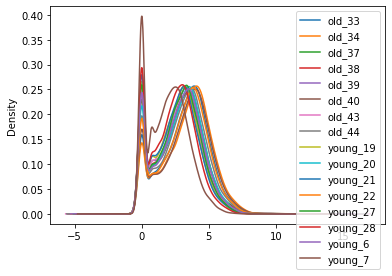

In [26]:
np.log(test+1).plot(kind='kde')

## single-cell DE

In [2]:
import scanpy as sc

In [27]:
rna_list = natsorted(glob('/tank/projects/kriukov_chromatin/RNA/GSE129788/*X.txt'))
genes = pd.read_csv(rna_list[0], '\t').index.tolist()
ann = pd.read_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/GSE129788_Supplementary_meta_data_Cell_Types_Etc.txt', sep='\t')
ann = ann.drop(0)
ann['ID'] = ann.NAME.apply(lambda x: x.split('data_')[1])
ann['miceID'] = ann.ID.apply(lambda x: x.split('_')[0])
ann['ageID'] = ann['animal_type'] + '_' +ann['miceID']
ann = ann.set_index('ID')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [79]:


res = pd.concat([pd.read_csv(rna_path, sep='\t') for rna_path in rna_list], axis=1) #open and merge datasets
X = res.T
var = pd.DataFrame(X.columns).set_index(0)
var['symbol'] = X.columns

In [100]:
anndata = sc.AnnData(X=X, obs=ann.loc[X.index], dtype=float)

In [101]:
anndata.write(filename='/tank/projects/kriukov_chromatin/RNA/GSE129788_scrna.h5ad')

... storing 'nGene' as categorical
... storing 'nUMI' as categorical
... storing 'cluster' as categorical
... storing 'animal_type' as categorical
... storing 'cell_classes' as categorical
... storing 'cell_type_age' as categorical
... storing 'miceID' as categorical
... storing 'ageID' as categorical


In [3]:
anndata = sc.read_h5ad('/tank/projects/kriukov_chromatin/RNA/GSE129788_scrna.h5ad')

In [4]:
#below DE analysis with diffxpy
import diffxpy.api as de

2022-07-15 13:56:38.622416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 13:56:39.021102: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-15 13:56:39.116663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 13:56:39.116708: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
anndata.obs.columns

Index(['NAME', 'nGene', 'nUMI', 'cluster', 'animal_type', 'cell_classes',
       'cell_type_age', 'miceID', 'ageID'],
      dtype='object')

In [6]:
anndata.obs['cell_type_age'].unique().tolist()

['MG_young',
 'NEUT_young',
 'DC_young',
 'MAC_young',
 'OLG_young',
 'OPC_young',
 'OEG_young',
 'mNEUR_young',
 'NendC_young',
 'ImmN_young',
 'ABC_young',
 'VLMC_young',
 'EC_young',
 'VSMC_young',
 'ASC_young',
 'NSC_young',
 'ARP_young',
 'NRP_young',
 'PC_young',
 'Hb_VC_young',
 'CPC_young',
 'TNC_young',
 'EPC_young',
 'MNC_young',
 'HypEPC_young',
 'MG_old',
 'DC_old',
 'MAC_old',
 'OLG_old',
 'OPC_old',
 'OEG_old',
 'mNEUR_old',
 'NendC_old',
 'ImmN_old',
 'ABC_old',
 'VLMC_old',
 'EC_old',
 'VSMC_old',
 'ASC_old',
 'NSC_old',
 'ARP_old',
 'PC_old',
 'Hb_VC_old',
 'CPC_old',
 'TNC_old',
 'EPC_old',
 'MNC_old',
 'NEUT_old',
 'NRP_old',
 'HypEPC_old']

In [7]:

#cross = [x + '_' + y for x,y in zip(anndata.obs['animal_type'].tolist(), anndata.obs['miceID'].tolist())]
#anndata.obs['age_miceID'] = cross

#subset = anndata.obs[anndata.obs['cell_type_age'].isin(['mNEUR_young', 'mNEUR_old'])].index

subset = anndata.obs[anndata.obs['cell_type_age'].isin(['ASC_young', 'ASC_old'])].index
annsub = anndata[subset, :]

In [9]:
annsub.obs.miceID.value_counts().sum()

6747

In [8]:
annsub.obs

,NAME,nGene,nUMI,cluster,animal_type,cell_classes,cell_type_age,miceID,ageID
6_AAACCTGTCACGCGGT,Aging_mouse_brain_portal_data_6_AAACCTGTCACGCGGT,2792,5951,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACCATGAGACAGAGA,Aging_mouse_brain_portal_data_6_AACCATGAGACAGAGA,2605,6082,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACCATGTCCTTGGTC,Aging_mouse_brain_portal_data_6_AACCATGTCCTTGGTC,636,947,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACTCTTAGGATGTAT,Aging_mouse_brain_portal_data_6_AACTCTTAGGATGTAT,1339,2274,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACTGGTTCCGTCAAA,Aging_mouse_brain_portal_data_6_AACTGGTTCCGTCAAA,3219,7182,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
...,...,...,...,...,...,...,...,...,...
44_GGACGTCAGTCCATAC,Aging_mouse_brain_portal_data_44_GGACGTCAGTCCATAC,659,1133,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44
44_GTAACGTAGAGGTTGC,Aging_mouse_brain_portal_data_44_GTAACGTAGAGGTTGC,938,1472,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44
44_GTTTCTAAGCAGACTG,Aging_mouse_brain_portal_data_44_GTTTCTAAGCAGACTG,968,1502,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44
44_TCAACGATCCAGAAGG,Aging_mouse_brain_portal_data_44_TCAACGATCCAGAAGG,1242,2066,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44


In [69]:
# import patsy
# pat = patsy.dmatrix(formula_like="~ 1 + animal_type + miceID", data=anndata.obs, return_type='dataframe')
# pat.shape
# np.linalg.matrix_rank(pat)

In [18]:
de.utils.preview_coef_names(
    sample_description=anndata.obs,
    formula="~ 1 + animal_type"
)

['Intercept', 'animal_type[T.young]']

In [ ]:
# test = de.test.wald(
#     data=annsub,
#     formula_loc="~1 + animal_type",
#     factor_loc_totest="animal_type",
# )

In [10]:
test_2s = de.test.two_sample(
    data=annsub, 
    grouping="animal_type",
    test="t_test"
)

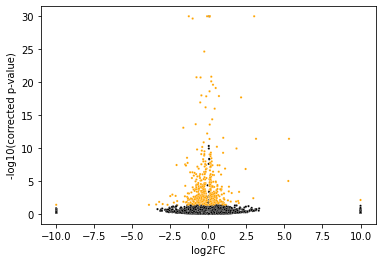

In [12]:
test_2s.summary().sort_values('log2fc')
test_2s.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=5)

In [13]:
res = test_2s.summary()

In [14]:
dr = res[(res.log2fc < 0)].sort_values('pval').gene[:10].values.tolist()
ur = res[(res.log2fc > 0)].sort_values('pval').gene[:10].values.tolist()
top = ur + dr

In [50]:
res[res.gene=='Pisd']

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
4375,Pisd,0.002124,0.043515,-0.248037,0.352176,False,False


In [54]:
res

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,Sox17,2.349176e-01,5.914318e-01,-1.323657,0.002042,False,False
1,Mrpl15,1.006543e-01,4.118609e-01,-0.183247,0.189106,False,False
2,Lypla1,2.876536e-01,6.493459e-01,-0.150355,0.118566,False,False
3,Tcea1,1.239994e-02,1.349966e-01,-0.247740,0.237608,False,False
4,Rgs20,6.180311e-03,8.712790e-02,0.458945,0.084375,False,False
...,...,...,...,...,...,...,...
14694,mt-Cytb,1.961433e-60,9.438414e-57,0.089686,4.701615,False,False
14695,Vamp7,9.824077e-02,4.075327e-01,-0.198812,0.161234,False,False
14696,AC168977.1,1.675183e-02,1.606818e-01,-1065.438419,0.001591,False,False
14697,PISD,2.927701e-41,5.283037e-38,-0.514795,1.189392,False,False


In [15]:
res.to_csv('subdata/scDE_ASC_results_GSE129788_old::young.csv')

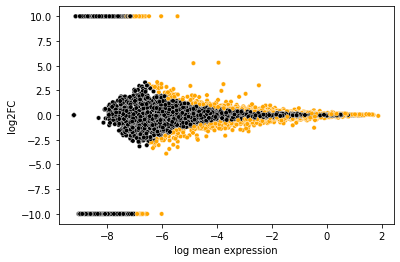

In [16]:
test_2s.plot_ma()